In [16]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import pandas as pd

sys.path.insert(0, '../../')

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [3]:
#load the data
full_model_data = ModelDataLoader('003')
data_df = full_model_data.df

In [4]:
#filter on six genres in scope 
in_scope_labels = [
    'rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country'
]
data_df = data_df[data_df['label'].isin(in_scope_labels)]

# Examine extracted features

## Check missing values

In [17]:
#check for missing data in the dataset -> no missing values identified
missing_data = data_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']

missing_chart = alt.Chart(missing_data).mark_bar().encode(
    x='Column:N', y='Missing Count:Q',
    color='Missing Count:Q').properties(title='# of missing values',
                                        height=300,
                                        width=750)

missing_chart

alt.Chart(...)

## Train - Test Split 

In [18]:
y = data_df['label']
x = data_df[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean',
    'spectral_centroids_accelerate_mean', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean', 'tempo', 'onset', 'contrast', 'tonnetz',
    'mfccs_min', 'mfccs_max'
]]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)

## Check correlation between variables

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_67514/2008680762.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = train_df.corr()


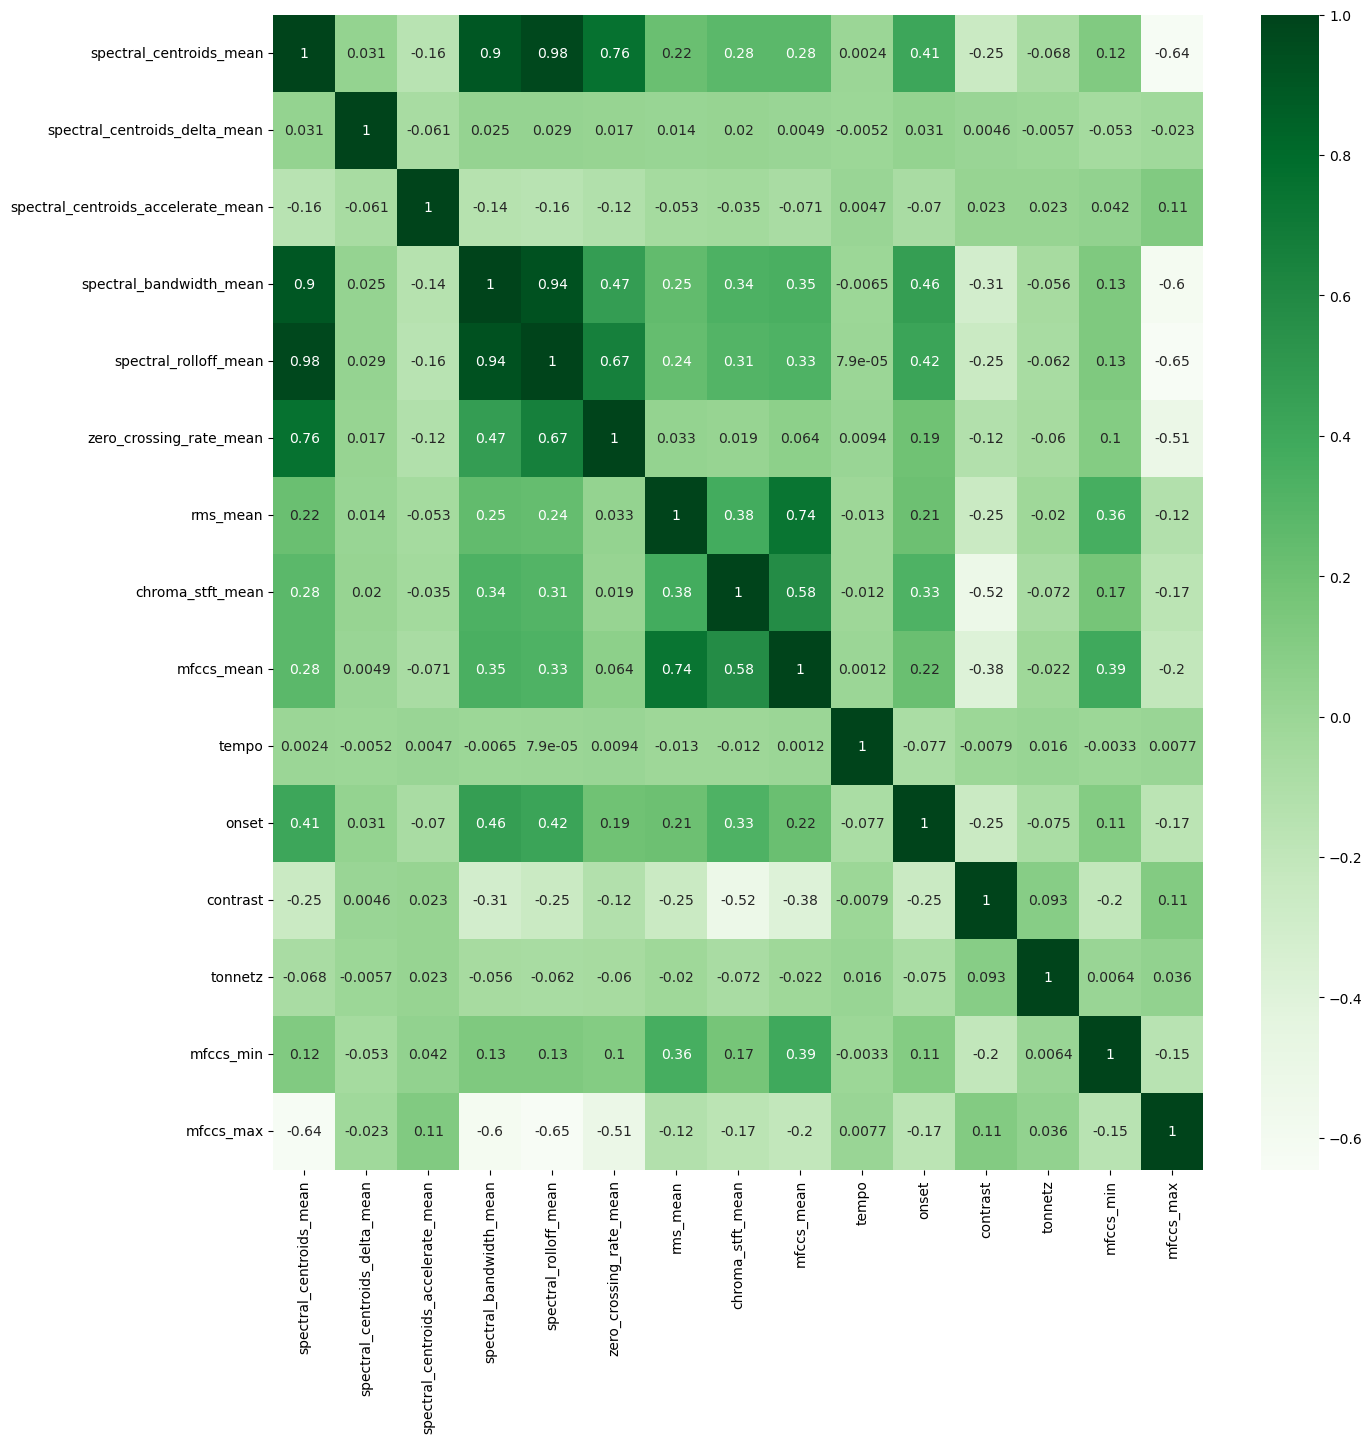

In [20]:
# check correlation between vars

#create correlation matrix
matrix = train_df.corr()

#plot correlation heatmap
plt.figure(figsize=(15, 15))

heatmap = sns.heatmap(matrix, cmap="Greens", annot=True)

plt.show()

#certain features are highly correlated: spectral bandwidth; spectral roll off; spectral centroids are highly correlated

## Check var distribution be genre 

In [21]:
#create a box plot function for a feature to show variability by genre
def box_plot(y_col):
    chart = alt.Chart(train_df).mark_boxplot(extent="min-max").encode(
        alt.X("label:N", title=None),
        alt.Y(y_col, title=None).scale(zero=False),
        alt.Color("label:N").legend(None),
    ).properties(width=200, title=y_col)
    return chart

In [22]:
box_plot('onset') | box_plot('spectral_centroids_delta_mean')
#visually onset shows good variability by genre, while certain other features,
#such as centroids_delta_mean do not show much variability be genre

alt.HConcatChart(...)

In [24]:
#two variables (spectral_centroids_accelerate and spectral_centroids_delta) do not show much variablity by genre.
#These variables might not be the best predictors of a genre.

box_plot('tempo') & box_plot('tonnetz') | box_plot('onset') & box_plot(
    'contrast') | box_plot('mfccs_min') & box_plot('mfccs_max')

alt.HConcatChart(...)

## Check class distribution 

In [13]:
#return a chart that shows % of data by genre
#rock has almost 50% of all data points
#classes might need to be balanced for further analysis

class_dis = pd.DataFrame(train_df['label'].value_counts(normalize=True) *
                         100).reset_index()

alt.Chart(class_dis).mark_bar().encode(x=alt.X('label:Q', title=None),
                                       y=alt.Y('index:N',
                                               sort='-x',
                                               title=None),
                                       color='label:Q')

alt.Chart(...)

## Calculate distance between groups based on a feature

In [30]:
sampled_df = train_df.groupby('label').sample(n=70)


def ec_distance(group1, group2):
    distance = np.sqrt(
        np.sum([(a - b) * (a - b) for a, b in zip(group1, group2)]))
    return distance


genres = train_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = sampled_df[sampled_df['label'] == i]['onset']
        group2 = sampled_df[sampled_df['label'] == j]['onset']

        if i == j:
            continue
        if (j, i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i, j] = round(dist, 2)

dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(),
                             columns=['genres', 'similarity']).head(20)
dist_df_top20

,genres,similarity
0,"(rock, jazz)",2.04
1,"(rock, country)",2.14
2,"(rock, classical)",2.34
3,"(hiphop, country)",2.80
4,"(jazz, country)",2.80
5,"(jazz, classical)",2.82
6,"(rock, hiphop)",3.40
7,"(country, classical)",3.51
8,"(electronic, country)",3.54
9,"(rock, electronic)",3.73


Text(0.5, 1.0, 'Most similar genre based on the onset feature')

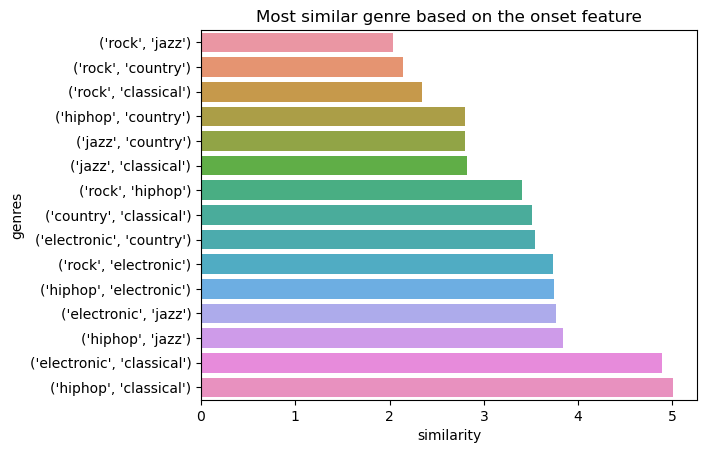

In [32]:
sns.barplot(x='similarity', y='genres', data=dist_df_top20)

plt.title('Most similar genre based on the onset feature')

#it appears that based on the onset feature jazz might likely to be incorrectly classified as rock;
#or country can be confused with rock
#further analysis will explore in detail which genres are likely to be incorrectly classified

## Feature importance using Random Forest 

In [36]:
#initialize and fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

#extract feature importance and feature names
feature_importances = rf.feature_importances_
feature_names = X_train.columns

In [37]:
#create feature importance dataframe
feature_imp_df = pd.DataFrame(feature_importances).set_index(feature_names)
feature_imp_df.reset_index(inplace=True)
feature_imp_df.columns = ['Features', 'Importance']
feature_imp_df = feature_imp_df.sort_values(by=['Importance'], ascending=False)
feature_imp_df['count cumsum'] = feature_imp_df['Importance'].cumsum()
feature_imp_df['cum_%'] = feature_imp_df['count cumsum'] / (
    feature_imp_df['Importance'].sum())

feature_imp_df

,Features,Importance,count cumsum,cum_%
10,onset,0.211222,0.211222,0.211222
3,spectral_bandwidth_mean,0.071233,0.282455,0.282455
5,zero_crossing_rate_mean,0.068934,0.351389,0.351389
7,chroma_stft_mean,0.068040,0.419429,0.419429
8,mfccs_mean,0.064023,0.483451,0.483451
4,spectral_rolloff_mean,0.063034,0.546485,0.546485
0,spectral_centroids_mean,0.055716,0.602201,0.602201
6,rms_mean,0.055082,0.657283,0.657283
9,tempo,0.054300,0.711583,0.711583
14,mfccs_max,0.053851,0.765435,0.765435


In [38]:
#plot feature importance - Pareto chart (bar plot + line plot)
alt.Chart(feature_imp_df).mark_bar().encode(
    x=alt.X('Features:N', title=None, sort='-y'),
    y=alt.Y('Importance:Q', title=None),
    color=alt.Color('Importance:Q',
                    legend=None)).properties(title='Feature Importance',
                                             width=400)
#define base for chart
base = alt.Chart(feature_imp_df).encode(
    x=alt.X('Features:N', title=None, sort='-y'))

#create bar chart
bar_chart = base.mark_bar(color='#ADD8E6').encode(
    y=alt.Y('Importance:Q', title=None)).properties(width=600)

#create line chart
line = base.mark_line(strokeWidth=3, color='#cb4154').encode(
    y=alt.Y('cum_%', title=None, axis=alt.Axis(format=".0%")),
    text=alt.Text('Importance:Q'))

#add text
text = base.mark_text(strokeWidth=3,
                      color='#cb4154',
                      align='left',
                      baseline='middle',
                      dx=-10,
                      dy=-10).encode(y=alt.Y('cum_%:Q', axis=None),
                                     text=alt.Text('cum_%:Q', format="0.0%"))

#combine into one chart and display
(bar_chart + line + text).resolve_scale(y='independent').properties(
    title='Feature Importance - Random Forest')

alt.LayerChart(...)